<a href="https://colab.research.google.com/github/talentrics/NWU_MSDS422_Assignments/blob/master/Assignment7_Convolutional_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MSDS 422 Assignment #7 - Convolutional Neural Networks

**by Daniel Macdonald @talentrics**

**Description**

This is the 7th assignment in NWU MSDS 422 - Practical Machine Learning

**text:** 

Initial source code from Aurelien Geron 'Machine Learning with SciKit Learn' Ch. 13
https://github.com/ageron/handson-ml

Additional resources & code referenced:

http://www.subsubroutine.com/sub-subroutine/2016/9/30/cats-and-dogs-and-convolutional-neural-networks

**Data Source (Cats vs. Dogs - Kaggle) - link to folder in google drive**

https://drive.google.com/open?id=1OGXhQaIiCOO67HPFHWHnRh_5jgx518Dx
**download this ipynb and install files to your current working directory**

**Colab Notebook:**
https://colab.research.google.com/drive/1ihd88__vcV52NdAXZaNGWT0Pq11PIL9W


**GitHub Repository **

https://github.com/talentrics/NWU_MSDS422_Assignments

**Table of contents:**

* System & Data Setup
* Model 1 - 5 layer DNN using Min-Max data Scaler
* Model 2 - 5 layer DNN using Robust data Scaler
* Model 3 - Convolutional Neural Network
* Conclusion

## System and Data Setup

Recommended - download this notebook as ipynb to your local disk.
To properly run the code, you will need to install the file linked from Google Drive to your current working directory.  Link to shared folder above.

In [0]:
import os
os.getcwd()

'/Users/talentrics/tfexperiments'

### file note: be sure to install provided folder of images 'cats_dogs_images' in your cwd
this is to ensure that the code below will reference & pull in the data properly

In [0]:
from __future__ import division, print_function, absolute_import

from skimage import color, io
from scipy.misc import imresize
import numpy as np
from sklearn.cross_validation import train_test_split
import os
import os.path  # for manipulation of file path names
from glob import glob

from matplotlib import pyplot as plt  # for display of images

import tflearn
from tflearn.data_utils import shuffle, to_categorical
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.estimator import regression
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation
from tflearn.metrics import Accuracy

# Open CV for image processing
# Installed on Mac with pip install opencv-python 
import cv2  

import tensorflow as tf

# "Human" sorting of file names facilitated by
# https://nedbatchelder.com/blog/200712/human_sorting.html
import re

import time

#suppress tf.logging
import logging
logging.getLogger('tensorflow').disabled = True

RANDOM_SEED = 9999

In [0]:
def tryint(s):
    try:
        return int(s)
    except:
        return s

def alphanum_key(s):
    """ Turn a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
    """
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]

def sort_nicely(l):
    """ Sort the given list in the way that humans expect.
    """
    l.sort(key=alphanum_key)
    
# Generate nicely sorted list of file names, excluding hidden files    
def directory_list (dir_name):
    start_list = os.listdir(dir_name)
    end_list = []
    for file in start_list:
        if (not file.startswith('.')):
            end_list.append(file) 
    end_list.sort(key = alphanum_key)        
    return(end_list)        
    
# Convert image to numpy array... 
# Three channels for color converted to grayscale
def parse_grayscale(image_file_path):
    image = cv2.imread(image_file_path, cv2.IMREAD_GRAYSCALE)
    return(image)
    
# Convert image to numpy array... three channels for color
def parse_color(image_file_path):
    image = cv2.imread(image_file_path, cv2.IMREAD_COLOR)
    # Default cv2 is BGR... need RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return(image)
  
def parse_grayscale_and_resize(image_file_path, size = (64, 64)):
    image = cv2.imread(image_file_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, size)
    return(image)

def parse_color_and_resize(image_file_path, size = (64, 64)):
    image = cv2.imread(image_file_path, cv2.IMREAD_COLOR)
    # Default cv2 is BGR... need RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, size)
    return(image)  
    
def show_grayscale_image(image):
    plt.imshow(image, cmap = 'gray') 
    plt.axis('off')
    plt.show()

def show_color_image(image):
    plt.imshow(image) 
    plt.axis('off')
    plt.show()   

# To make output stable across runs
def reset_graph(seed= RANDOM_SEED):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

### Import Picture Files

In [0]:
# establish directory reference & directory lists
# if folder 'cats_dogs_images' is in your cwd, this works:

cat_image_dir_name = 'cats_dogs_images/cats'
cat_file_names = directory_list('cats_dogs_images/cats')

dog_image_dir_name = 'cats_dogs_images/dogs'
dog_file_names = directory_list('cats_dogs_images/dogs')

# create dict of cat & dog file shapes for each image:

cats_shapes = []

for ifile in range(len(cat_file_names)):
    image_file_path = os.path.join(cat_image_dir_name, cat_file_names[ifile])
    image = parse_color(image_file_path)
    cats_shapes.append(image.shape)   

dogs_shapes = []

for ifile in range(len(cat_file_names)):
    image_file_path = os.path.join(dog_image_dir_name, dog_file_names[ifile])
    image = parse_color(image_file_path)
    dogs_shapes.append(image.shape) 


Create 4 file np arrays - 1000x Cats & Dogs in both 128x128 greyscale & 64x64 color

In [0]:
# Create cats_1000_128_128_1 and np array for 1000 cat images in greyscale
cats_1000_128_128_1 = np.zeros((1000, 128, 128, 1))  

for ifile in range(len(cat_file_names)):
    image_file_path = os.path.join('cats_dogs_images/cats', cat_file_names[ifile])
    image = parse_grayscale_and_resize(image_file_path, size = (128, 128))
    cats_1000_128_128_1[ifile,:,:,0] = image
    
# Create dogs_1000_128_128_1 and numpy array for 1000 dog images in grayscale   
dogs_1000_128_128_1 = np.zeros((1000, 128, 128, 1))  

for ifile in range(len(dog_file_names)):
    image_file_path = os.path.join('cats_dogs_images/dogs', dog_file_names[ifile])
    image = parse_grayscale_and_resize(image_file_path, size = (128, 128))
    dogs_1000_128_128_1[ifile,:,:,0] = image   

# Create cats_1000_64_64_3 and numpy array for 1000 cat images in color  
cats_1000_64_64_3 = np.zeros((1000, 64, 64, 3))  
    
for ifile in range(len(cat_file_names)):
    image_file_path = os.path.join(cat_image_dir_name, cat_file_names[ifile])
    image = parse_color_and_resize(image_file_path, size = (64, 64))
    cats_1000_64_64_3[ifile,:,:,:] = image
        
# Create dogs_1000_64_64_3 and numpy array for 1000 dog images in color   
dogs_1000_64_64_3 = np.zeros((1000, 64, 64, 3))  

for ifile in range(len(dog_file_names)):
    image_file_path = os.path.join(dog_image_dir_name, dog_file_names[ifile])
    image = parse_color_and_resize(image_file_path, size = (64, 64))
    dogs_1000_64_64_3[ifile,:,:,:] = image

Save arrays to new directories

In [0]:
os.mkdir('outdir_color') #only needed 1x
os.mkdir('outdir_greyscale') #only needed 1x

In [0]:
os.listdir() # check new directorys exist

['cats_dogs_images',
 '.DS_Store',
 'Assignment7_Convolutional_Networks.ipynb',
 'outdir_greyscale',
 'Draft_assignment2.ipynb',
 'outdir_color',
 '.gitignore',
 '.ipynb_checkpoints',
 '.git',
 '.vscode']

In [0]:
#save new np array to new directory
np.save(os.path.join('outdir_color', 'cats_1000_64_64_3.npy'), cats_1000_64_64_3)
np.save(os.path.join('outdir_color', 'dogs_1000_64_64_3.npy'), dogs_1000_64_64_3)
np.save(os.path.join('outdir_greyscale', 'cats_1000_128_128_1.npy'), cats_1000_128_128_1)
np.save(os.path.join('outdir_greyscale', 'dogs_1000_128_128_1.npy'), dogs_1000_128_128_1)

In [0]:
os.listdir('outdir_greyscale') #check array saved correctly

['cats_1000_128_128_1.npy', 'dogs_1000_128_128_1.npy']

In [0]:
os.listdir('outdir_color') #check array saved correctly

['cats_1000_64_64_3.npy', 'dogs_1000_64_64_3.npy']

Have a look at cuteness to check things are working and enjoy the work so far:

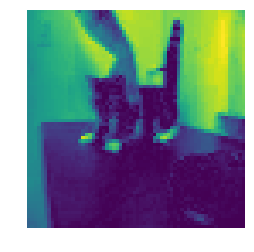

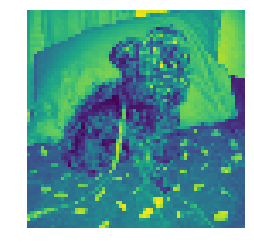

In [0]:
# Examine first cat and first dog color images
show_color_image(cats_1000_64_64_3[0,:,:,2])
show_color_image(dogs_1000_64_64_3[0,:,:,2])

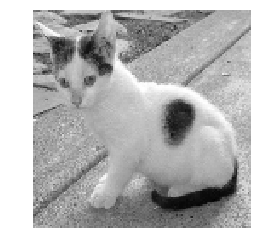

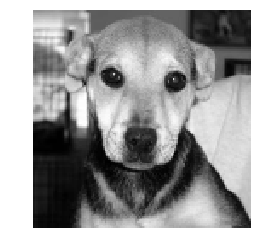

In [0]:
# Examine first cat and first dog grayscale images
show_grayscale_image(cats_1000_128_128_1[3,:,:,0])
show_grayscale_image(dogs_1000_128_128_1[4,:,:,0])

### split training/test data and create scaler data sets

#### 1) first create X_data & y_data for model 1 & 2 using greyscale images (y = target 0/1)

In [0]:
# Stack the numpy arrays for the inputs
X_cat_dog = np.concatenate((cats_1000_128_128_1, dogs_1000_128_128_1), axis = 0) 
X_cat_dog = X_cat_dog.reshape(-1,width*height) # note coversion to 16384 (128x128) inputs
# Define the labels to be used 1000 cats = 0 1000 dogs = 1
y_cat_dog = np.concatenate((np.zeros((1000), dtype = np.int32), 
                      np.ones((1000), dtype = np.int32)), axis = 0)
X_cat_dog.shape #check data shape

(2000, 16384)

In [0]:
y_cat_dog.shape #check target data shape

(2000,)

#### 2) second create scaler variables for model 1 (Min_Max) & model 2 (Robust) 

In [0]:
#Scikit Learn for min-max scaling of the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(np.array([0., 255.]).reshape(-1,1)) 
X_cat_dog_min_max = scaler.transform(X_cat_dog)

In [0]:
#Scikit Learn for min-max scaling of the data
from sklearn.preprocessing import RobustScaler
scaler2 = RobustScaler()
scaler2.fit(np.array([0., 255.]).reshape(-1,1)) 
X_cat_dog_robust_scale = scaler2.transform(X_cat_dog)

In [0]:
X_cat_dog_min_max.shape

(2000, 16384)

In [0]:
X_cat_dog_robust_scale.shape

(2000, 16384)

#### 3) split train & test data for model 1, 2 (greyscale using scalers)

In [0]:
# Scikit Learn for random splitting of the data  
from sklearn.model_selection import train_test_split

# Random splitting of the data in to training (80%) and test (20%)  
X_train_m1, X_test_m1, y_train_m1, y_test_m1 = \
    train_test_split(X_cat_dog_min_max, y_cat_dog, test_size=0.20, 
                     random_state = RANDOM_SEED)

# Random splitting of the data in to training (80%) and test (20%)  
X_train_m2, X_test_m2, y_train_m2, y_test_m2 = \
    train_test_split(X_cat_dog_robust_scale, y_cat_dog, test_size=0.20, 
                     random_state = RANDOM_SEED)

#### 4) create train/test data for model 3 (unscaled color 64x64)

In [0]:
X_cat_dog_m3 = np.concatenate((cats_1000_64_64_3, dogs_1000_64_64_3), axis = 0) 
#X_cat_dog = X_cat_dog.reshape(-1,width*height) # note coversion to 16384 (128x128) inputs
#Define the labels to be used 1000 cats = 0 1000 dogs = 1
y_cat_dog_m3 = np.concatenate((np.zeros((1000), dtype = np.int32), 
                      np.ones((1000), dtype = np.int32)), axis = 0)
X_cat_dog_m3.shape #check data shape

(2000, 64, 64, 3)

In [0]:
y_cat_dog_m3.shape #check data shape

(2000,)

In [0]:
# test-train split   
X_m3, X_test_m3, Y_m3, Y_test_m3 = train_test_split(X_cat_dog_m3, y_cat_dog_m3, test_size=0.2, random_state=42)

# encode the Ys
Y_m3 = to_categorical(Y_m3, 2)
Y_test_m3 = to_categorical(Y_test_m3, 2)

In [0]:
X_m3.shape

(1600, 64, 64, 3)

In [0]:
Y_m3.shape

(1600, 2)

## Prepare Model 1 & 2 (5 layer DNN)
data source - 128 x 128 greyscale images passed through multiple layers

#### define neuron layer, hyperparameters & model design

In [0]:
# setup - define neuron layer
def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="kernel")
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        Z = tf.matmul(X, W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z

define the hyperparameters for the model

In [0]:
#set height & width
height = 128
width = 128 

# 300 and 100 nodes for layers 1 and 2 as used with MNIST from Geron
n_hidden1 = 2000
n_hidden2 = 1500
n_hidden3 = 1000
n_hidden4 = 500

channels = 1  # When working with color images use channels = 3

n_inputs = height * width

#CatsDogs# Has two output values # MNIST had ten digits n_outputs = 10  
n_outputs = 2  # binary classification for Cats and Dogs, 1 output node 0/1

reset_graph()

# dnn... Deep neural network model from Geron Chapter 10
# Note that this model makes no use of the fact that we have
# pixel data arranged in rows and columns
# So a 64x64 matrix of raster values becomes a vector of 4096 input variables
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

define the model - 5 layer deep neural network (dnn)

In [0]:
with tf.name_scope("dnn"):
    hidden1 = neuron_layer(X, n_hidden1, name="hidden1",
                           activation=tf.nn.relu)
    hidden2 = neuron_layer(hidden1, n_hidden2, name="hidden2",
                           activation=tf.nn.relu)
    hidden3 = neuron_layer(hidden2, n_hidden3, name="hidden3",
                           activation=tf.nn.relu)
    hidden4 = neuron_layer(hidden3, n_hidden4, name="hidden4",
                           activation=tf.nn.relu)
    logits = neuron_layer(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))    

init = tf.global_variables_initializer()
saver = tf.train.Saver()

## Model 1 - 50 epochs using Min_max scaler

In [0]:
%%time

init = tf.global_variables_initializer()    

n_epochs = 50
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(y_train_m1.shape[0] // batch_size):
            X_batch = X_train_m1[iteration*batch_size:(iteration + 1)*batch_size,:]
            y_batch = y_train_m1[iteration*batch_size:(iteration + 1)*batch_size]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test_m1, y: y_test_m1})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

        save_path = saver.save(sess, "./my_catdog_model_m1")

0 Train accuracy: 0.63 Test accuracy: 0.5075
1 Train accuracy: 0.65 Test accuracy: 0.515
2 Train accuracy: 0.71 Test accuracy: 0.525
3 Train accuracy: 0.71 Test accuracy: 0.525
4 Train accuracy: 0.77 Test accuracy: 0.53
5 Train accuracy: 0.75 Test accuracy: 0.53
6 Train accuracy: 0.79 Test accuracy: 0.5325
7 Train accuracy: 0.79 Test accuracy: 0.535
8 Train accuracy: 0.79 Test accuracy: 0.5375
9 Train accuracy: 0.78 Test accuracy: 0.5375
10 Train accuracy: 0.86 Test accuracy: 0.58
11 Train accuracy: 0.88 Test accuracy: 0.5775
12 Train accuracy: 0.9 Test accuracy: 0.5775
13 Train accuracy: 0.8 Test accuracy: 0.5425
14 Train accuracy: 0.79 Test accuracy: 0.535
15 Train accuracy: 0.88 Test accuracy: 0.5775
16 Train accuracy: 0.78 Test accuracy: 0.5375
17 Train accuracy: 0.75 Test accuracy: 0.5575
18 Train accuracy: 0.91 Test accuracy: 0.585
19 Train accuracy: 0.94 Test accuracy: 0.595
20 Train accuracy: 0.94 Test accuracy: 0.58
21 Train accuracy: 0.86 Test accuracy: 0.5675
22 Train accura

## Model 2 - 75 epochs using Robust scaler

In [0]:
%%time

init = tf.global_variables_initializer()    

n_epochs = 75
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(y_train_m2.shape[0] // batch_size):
            X_batch = X_train_m2[iteration*batch_size:(iteration + 1)*batch_size,:]
            y_batch = y_train_m2[iteration*batch_size:(iteration + 1)*batch_size]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test_m2, y: y_test_m2})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

        save_path = saver.save(sess, "./my_catdog_model_m2")

0 Train accuracy: 0.6 Test accuracy: 0.4825
1 Train accuracy: 0.64 Test accuracy: 0.5475
2 Train accuracy: 0.85 Test accuracy: 0.4975
3 Train accuracy: 0.96 Test accuracy: 0.5225
4 Train accuracy: 1.0 Test accuracy: 0.5425
5 Train accuracy: 1.0 Test accuracy: 0.5175
6 Train accuracy: 1.0 Test accuracy: 0.5175
7 Train accuracy: 1.0 Test accuracy: 0.5225
8 Train accuracy: 1.0 Test accuracy: 0.5375
9 Train accuracy: 1.0 Test accuracy: 0.5525
10 Train accuracy: 1.0 Test accuracy: 0.55
11 Train accuracy: 1.0 Test accuracy: 0.55
12 Train accuracy: 1.0 Test accuracy: 0.55
13 Train accuracy: 1.0 Test accuracy: 0.545
14 Train accuracy: 1.0 Test accuracy: 0.5475
15 Train accuracy: 1.0 Test accuracy: 0.55
16 Train accuracy: 1.0 Test accuracy: 0.55
17 Train accuracy: 1.0 Test accuracy: 0.545
18 Train accuracy: 1.0 Test accuracy: 0.545
19 Train accuracy: 1.0 Test accuracy: 0.5475
20 Train accuracy: 1.0 Test accuracy: 0.5425
21 Train accuracy: 1.0 Test accuracy: 0.5425
22 Train accuracy: 1.0 Test ac

## Model 3 - 100 epochs using Convolutional Neural Network (CNN)
data source - 64 x 64 color images passed through CNN using tflearn

#### hyperparameter setup & image transformation
http://www.subsubroutine.com/sub-subroutine/2016/9/30/cats-and-dogs-and-convolutional-neural-networks

In [0]:
reset_graph()

#set height & width
height = 64
width = 64
channels = 3

###################################
# Image transformations
###################################

# normalisation of images
img_prep = ImagePreprocessing()
img_prep.add_featurewise_zero_center()
img_prep.add_featurewise_stdnorm()

# Create extra synthetic training data by flipping & rotating images
img_aug = ImageAugmentation()
img_aug.add_random_flip_leftright()
img_aug.add_random_rotation(max_angle=25.)

In [0]:
###################################
# Define network architecture
###################################

# Input is a 32x32 image with 3 color channels (red, green and blue)
network = input_data(shape=[None, 64, 64, 3],
                     data_preprocessing=img_prep,
                     data_augmentation=img_aug)

# 1: Convolution layer with 32 filters, each 3x3x3
conv_1 = conv_2d(network, 32, 3, activation='relu', name='conv_1')

# 2: Max pooling layer
network = max_pool_2d(conv_1, 2)

# 3: Convolution layer with 64 filters
conv_2 = conv_2d(network, 64, 3, activation='relu', name='conv_2')

# 4: Convolution layer with 64 filters
conv_3 = conv_2d(conv_2, 64, 3, activation='relu', name='conv_3')

# 5: Max pooling layer
network = max_pool_2d(conv_3, 2)

# 6: Fully-connected 512 node layer
network = fully_connected(network, 512, activation='relu')

# 7: Dropout layer to combat overfitting
network = dropout(network, 0.5)

# 8: Fully-connected layer with two outputs
network = fully_connected(network, 2, activation='softmax')

# Configure how the network will be trained
acc = Accuracy(name="Accuracy")
network = regression(network, optimizer='adam',
                     loss='categorical_crossentropy',
                     learning_rate=0.0005, metric=acc)

# Wrap the network in a model object
model = tflearn.DNN(network, checkpoint_path='model_cat_dog_6.tflearn', max_checkpoints = 3,
                    tensorboard_verbose = 3, tensorboard_dir='tmp/tflearn_logs/')

In [0]:
%%time
###################################
# Train model for 100 epochs
###################################
model.fit(X_m3, Y_m3, validation_set=(X_test_m3, Y_test_m3), batch_size=500,
      n_epoch=100, run_id='model_cat_dog_6', show_metric=True)

model.save('model_cat_dog_6_final.tflearn')

Training Step: 401  | total loss: 0.18230 | time: 7.681s
| Adam | epoch: 101 | loss: 0.18230 - Accuracy: 0.9346 -- iter: 1500/1600
Training Step: 402  | total loss: 0.17449 | time: 9.571s
| Adam | epoch: 101 | loss: 0.17449 - Accuracy: 0.9391 | val_loss: 0.57675 - val_acc: 0.7575 -- iter: 1600/1600
--
CPU times: user 2h 2min 33s, sys: 19min 1s, total: 2h 21min 34s
Wall time: 17min 59s


## Conclusion

#### Model 1 - 5 layer DNN using Min_Max scaler (50 epochs) - time: 15 mins accuracy: training = .99 / test .58 (overfit)
#### Model 2 - 5 layer DNN using Robust scaler (75 epochs) - time: 23 mins accuracy: training = 1 / test .58 (overfit)
#### Model 3 - tflearn CNN using (64 x 64 x 3) (100 epochs) - time: 18 mins; accuracy = .93 (*recommended model)

In the case of image recognition, traditional deep neural network (dnn) models under perform regardless of hidden layer configuration or number of epochs.  This is likely due to their inability to drop inputs.  Instead, Model 3 uses a technique that convoludes (filters) the input multiple times, pools the data and then feeds that into a 'fully connected' dnn model over multiple layers.  This takes a lot more computing power to process, but the result is a much higher predictive accuracy.